# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1.limited",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run138', 'ORACLE.run114', 'ORACLE.run150', 'ORACLE.run132', 'ORACLE.run18', 'ORACLE.run126', 'ORACLE.run144', 'ORACLE.run120'}


{'Wisig_3', 'Wisig_2', 'Wisig_4', 'Wisig_1'}


tensor([[[-0.5157,  1.0145,  1.3442,  ...,  0.0000, -0.4481,  1.2259],
         [-0.0845, -0.3720, -0.9807,  ...,  0.1099, -0.7947,  0.3973]],

        [[-0.5868, -0.5700,  1.8694,  ...,  0.3102,  0.1844, -0.8131],
         [-0.1174,  0.6958, -0.5868,  ...,  0.4359,  0.2766,  0.0503]],

        [[-2.2739, -0.3356,  1.0488,  ...,  0.5454, -0.8810, -0.2769],
         [ 0.5118,  0.6041, -1.1411,  ...,  0.3524,  0.9062, -1.2502]],

        ...,

        [[-0.6893, -0.6220,  1.3282,  ..., -0.1597,  0.9667,  1.0423],
         [ 0.7734, -0.2774,  0.1681,  ..., -0.4960,  0.8742,  0.9331]],

        [[-0.7212,  0.3487, -0.0238,  ..., -0.2932, -0.0872,  0.1664],
         [-1.1174, -0.7767,  0.2853,  ...,  0.4121,  0.7846,  0.2615]],

        [[-0.2759,  1.1037,  0.5113,  ...,  0.2516,  0.9414,  0.5437],
         [-0.2678,  0.0649,  1.2011,  ...,  0.5032,  0.8034,  0.3977]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.0280, train_label_loss: 2.7969, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3324.7713, train_label_loss: 2.7717, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3391.4810, train_label_loss: 1.6583, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 3513.8054, train_label_loss: 1.3377, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 3376.8547, train_label_loss: 1.2816, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 3387.8542, train_label_loss: 1.1381, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 3392.6607, train_label_loss: 0.8632, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 3405.9788, train_label_loss: 1.8375, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 3366.2615, train_label_loss: 1.4966, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3449.9020, train_label_loss: 0.8018, 


epoch: 1, source_val_acc_label: 0.5429, target_val_acc_label: 0.6112, source_val_label_loss: 1.2015, target_val_label_loss: 5.5983, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.2004, train_label_loss: 1.4609, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3339.3038, train_label_loss: 1.6285, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3363.9294, train_label_loss: 0.7087, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3585.2671, train_label_loss: 0.6032, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3362.1869, train_label_loss: 0.8394, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3394.3107, train_label_loss: 1.1493, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3394.8389, train_label_loss: 0.5375, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3394.7062, train_label_loss: 1.4550, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3395.0055, train_label_loss: 0.6432, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3382.6454, train_label_loss: 0.4633, 


epoch: 2, source_val_acc_label: 0.5943, target_val_acc_label: 0.6448, source_val_label_loss: 1.0693, target_val_label_loss: 7.0780, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.1142, train_label_loss: 0.8080, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3335.3985, train_label_loss: 1.3012, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3361.4876, train_label_loss: 0.5064, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 3897.3092, train_label_loss: 1.1411, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 3884.1632, train_label_loss: 1.2317, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 3949.8232, train_label_loss: 1.0705, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 3993.6551, train_label_loss: 0.5358, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 3894.5029, train_label_loss: 0.9896, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 4051.2143, train_label_loss: 0.9557, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3853.3037, train_label_loss: 0.5330, 


epoch: 3, source_val_acc_label: 0.6111, target_val_acc_label: 0.6602, source_val_label_loss: 1.0471, target_val_label_loss: 8.3452, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.8956, train_label_loss: 0.8051, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3875.2968, train_label_loss: 0.4578, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3912.6300, train_label_loss: 0.8377, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3938.7217, train_label_loss: 0.4639, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3886.3701, train_label_loss: 0.4003, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3955.5241, train_label_loss: 0.6000, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 4170.9247, train_label_loss: 0.4902, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 4011.8078, train_label_loss: 0.6392, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 4150.9638, train_label_loss: 0.3832, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 4509.3328, train_label_loss: 0.9311, 


epoch: 4, source_val_acc_label: 0.6113, target_val_acc_label: 0.6572, source_val_label_loss: 1.0693, target_val_label_loss: 9.8865, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 5.0671, train_label_loss: 0.8448, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3928.0818, train_label_loss: 0.4207, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3892.3147, train_label_loss: 0.6313, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3894.5990, train_label_loss: 0.5740, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3851.8852, train_label_loss: 0.7566, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3939.6754, train_label_loss: 0.5184, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 4015.0810, train_label_loss: 0.3371, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3997.4728, train_label_loss: 0.9731, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 4029.2502, train_label_loss: 0.3801, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 4023.9975, train_label_loss: 0.6073, 


epoch: 5, source_val_acc_label: 0.6184, target_val_acc_label: 0.6800, source_val_label_loss: 1.0838, target_val_label_loss: 10.5545, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 3.9022, train_label_loss: 0.3955, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2930.4934, train_label_loss: 0.9072, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2940.2936, train_label_loss: 0.5269, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2961.2743, train_label_loss: 0.6621, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2936.6508, train_label_loss: 0.5351, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2984.9061, train_label_loss: 0.6579, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2950.2178, train_label_loss: 0.3531, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2993.1627, train_label_loss: 1.0287, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3002.5150, train_label_loss: 0.4252, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2981.7024, train_label_loss: 0.4100, 


epoch: 6, source_val_acc_label: 0.6002, target_val_acc_label: 0.6729, source_val_label_loss: 1.1604, target_val_label_loss: 11.4948, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.0431, train_label_loss: 0.5701, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3308.5247, train_label_loss: 0.3806, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3350.4098, train_label_loss: 0.5479, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3479.1969, train_label_loss: 0.3558, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 3614.1704, train_label_loss: 0.3214, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2992.1680, train_label_loss: 0.1608, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2972.7261, train_label_loss: 0.6495, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2975.8065, train_label_loss: 0.6230, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3028.2167, train_label_loss: 0.5016, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2992.6341, train_label_loss: 0.8218, 


epoch: 7, source_val_acc_label: 0.6105, target_val_acc_label: 0.6784, source_val_label_loss: 1.2299, target_val_label_loss: 13.1138, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.7742, train_label_loss: 0.3682, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2995.4211, train_label_loss: 0.5343, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3235.7022, train_label_loss: 0.8049, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3470.8654, train_label_loss: 0.1743, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 3412.0894, train_label_loss: 0.3492, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 3347.7438, train_label_loss: 0.6573, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 3413.2602, train_label_loss: 0.3200, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 3534.4103, train_label_loss: 0.3618, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 3411.7554, train_label_loss: 0.5020, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3517.1736, train_label_loss: 0.6238, 


epoch: 8, source_val_acc_label: 0.6053, target_val_acc_label: 0.6770, source_val_label_loss: 1.2945, target_val_label_loss: 13.6583, 


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.7376, train_label_loss: 0.2484, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3313.4633, train_label_loss: 0.1551, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3341.6123, train_label_loss: 0.5700, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3466.4735, train_label_loss: 0.3533, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3384.8254, train_label_loss: 0.1936, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3377.9969, train_label_loss: 0.1342, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3548.0703, train_label_loss: 0.2498, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3944.8176, train_label_loss: 0.2524, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 4284.9033, train_label_loss: 0.6832, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3746.6955, train_label_loss: 0.2641, 


epoch: 9, source_val_acc_label: 0.6085, target_val_acc_label: 0.6805, source_val_label_loss: 1.3713, target_val_label_loss: 15.1339, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 3.1673, train_label_loss: 0.6740, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3011.6406, train_label_loss: 0.4089, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3018.7230, train_label_loss: 0.6041, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2999.6762, train_label_loss: 0.3273, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2946.5512, train_label_loss: 0.4742, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2981.4991, train_label_loss: 0.6330, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3001.9346, train_label_loss: 0.1833, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2975.7364, train_label_loss: 0.0928, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2983.3796, train_label_loss: 0.3954, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2983.8099, train_label_loss: 0.2088, 


epoch: 10, source_val_acc_label: 0.5998, target_val_acc_label: 0.6886, source_val_label_loss: 1.4823, target_val_label_loss: 16.1956, 


New best


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.0029, train_label_loss: 0.2535, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3381.6600, train_label_loss: 0.1747, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3368.6275, train_label_loss: 0.5975, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3335.2217, train_label_loss: 0.0551, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3450.9056, train_label_loss: 0.2929, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3384.4219, train_label_loss: 0.1624, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2960.7731, train_label_loss: 0.3685, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2959.0750, train_label_loss: 0.3396, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2934.1194, train_label_loss: 0.1616, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2961.1861, train_label_loss: 0.2430, 


epoch: 11, source_val_acc_label: 0.6004, target_val_acc_label: 0.6820, source_val_label_loss: 1.4966, target_val_label_loss: 16.7128, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.7555, train_label_loss: 0.4845, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2928.5987, train_label_loss: 0.3204, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2987.4590, train_label_loss: 0.2719, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3391.3065, train_label_loss: 0.0930, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3406.2541, train_label_loss: 0.0770, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3370.7000, train_label_loss: 0.1839, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3380.2263, train_label_loss: 0.3087, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3417.7510, train_label_loss: 0.5155, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3323.7084, train_label_loss: 0.2771, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3469.7846, train_label_loss: 0.0082, 


epoch: 12, source_val_acc_label: 0.5921, target_val_acc_label: 0.6843, source_val_label_loss: 1.6495, target_val_label_loss: 18.1569, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.1413, train_label_loss: 0.3731, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3343.1573, train_label_loss: 0.5251, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 3407.7442, train_label_loss: 0.1780, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3616.9142, train_label_loss: 0.0181, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3421.6880, train_label_loss: 0.1023, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3401.1076, train_label_loss: 0.4110, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3424.4722, train_label_loss: 0.3682, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3435.2035, train_label_loss: 0.1082, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3448.8476, train_label_loss: 0.2286, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3924.6239, train_label_loss: 0.0174, 


epoch: 13, source_val_acc_label: 0.5957, target_val_acc_label: 0.6846, source_val_label_loss: 1.6909, target_val_label_loss: 19.3854, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.5048, train_label_loss: 0.2202, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3714.8278, train_label_loss: 0.2249, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3955.0087, train_label_loss: 0.5476, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 4108.6938, train_label_loss: 0.0079, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3508.8052, train_label_loss: 0.2068, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3386.7749, train_label_loss: 0.3255, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3380.9083, train_label_loss: 0.1279, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3381.3530, train_label_loss: 0.1123, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3827.0957, train_label_loss: 0.5118, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3807.0527, train_label_loss: 0.0896, 


epoch: 14, source_val_acc_label: 0.5959, target_val_acc_label: 0.6872, source_val_label_loss: 1.7839, target_val_label_loss: 20.5549, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

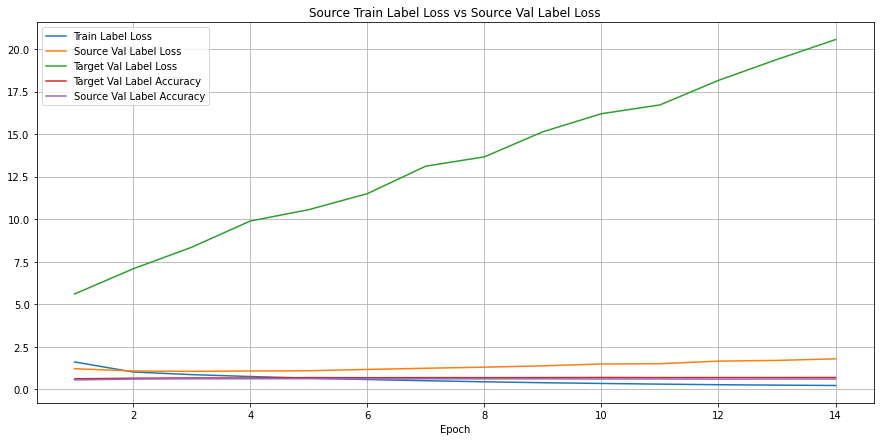

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

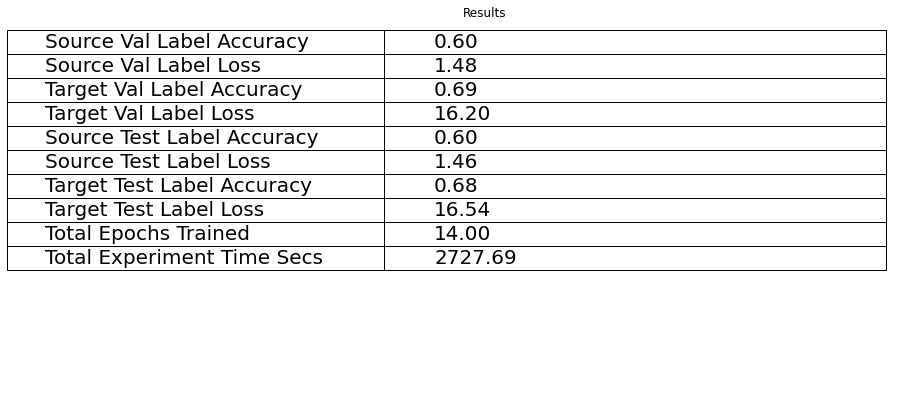

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

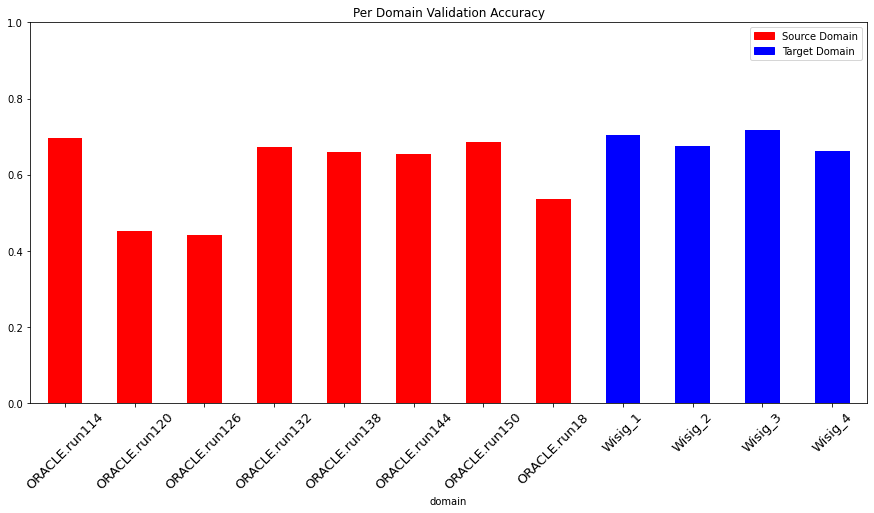

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.60205078125 Target Test Label Accuracy: 0.6833720330237358
Source Val Label Accuracy: 0.5998372395833333 Target Val Label Accuracy: 0.6885889651531151


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1.limited", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}